In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'mejiro':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [12]:
import numpy as np
import time
import pickle
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from lenstronomy.LensModel.lens_model import LensModel
from pyHalo.preset_models import CDM

from mejiro.plots import diagnostic_plot, plot
from mejiro.helpers.lens import Lens
from mejiro.helpers.test_physical_lens import TestPhysicalLens

plt.style.use(f'{repo_path}/mejiro/mplstyle/science.mplstyle')

np.random.seed(92)

In [3]:
csv = os.path.join(repo_path, 'data', 'roman_spacecraft_and_instrument_parameters.csv')
figure_dir = os.path.join(repo_path, 'figures')
array_dir = os.path.join(repo_path, 'output', 'arrays')
pickle_dir = os.path.join(repo_path, 'output', 'pickles')

In [4]:
lens = TestPhysicalLens()

In [5]:
realizationCDM = CDM(lens.z_lens, lens.z_source, cone_opening_angle_arcsec=10, LOS_normalization=0.0)
print(f'Realization contains {len(realizationCDM.halos)} halos.')

Realization contains 10021 halos.


Text(0, 0.5, 'n(M)')

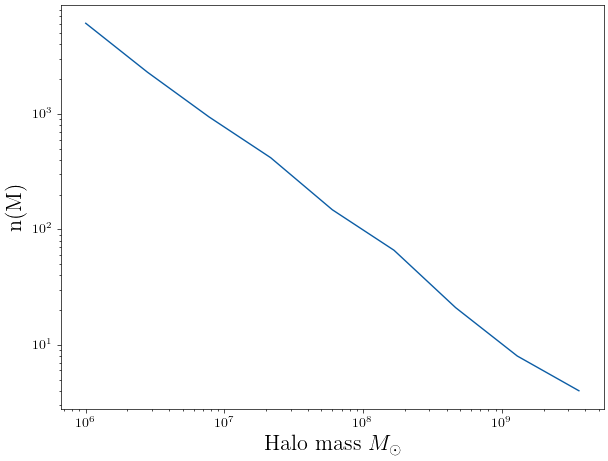

In [6]:
cdm_halo_masses = [halo.mass for halo in realizationCDM.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

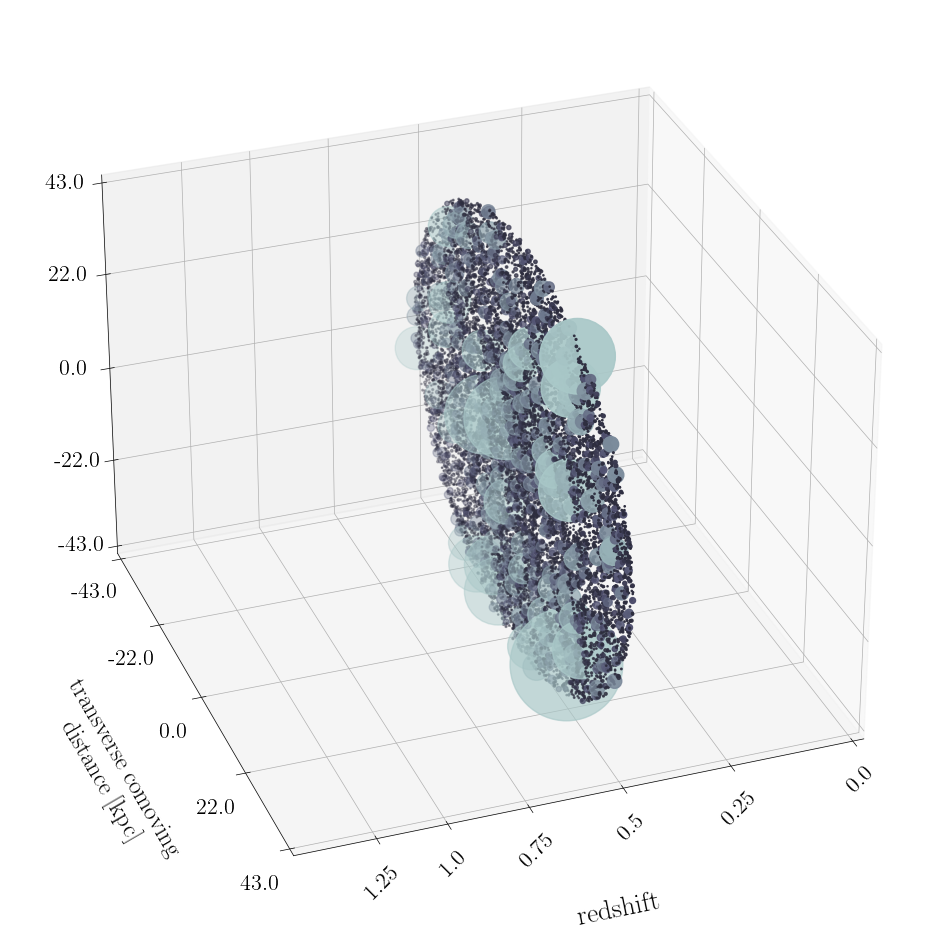

In [7]:
fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realizationCDM.plot(ax)

In [8]:
halo_lens_model_list, halo_redshift_list, kwargs_halos, _ = realizationCDM.lensing_quantities()

# for some reason, halo_lens_model_list and kwargs_halos are lists, but halo_redshift_list is an ndarray
halo_redshift_list = halo_redshift_list.tolist()

lens_with_subhalos = TestPhysicalLens()

lens_with_subhalos.add_subhalos(halo_lens_model_list, halo_redshift_list, kwargs_halos)

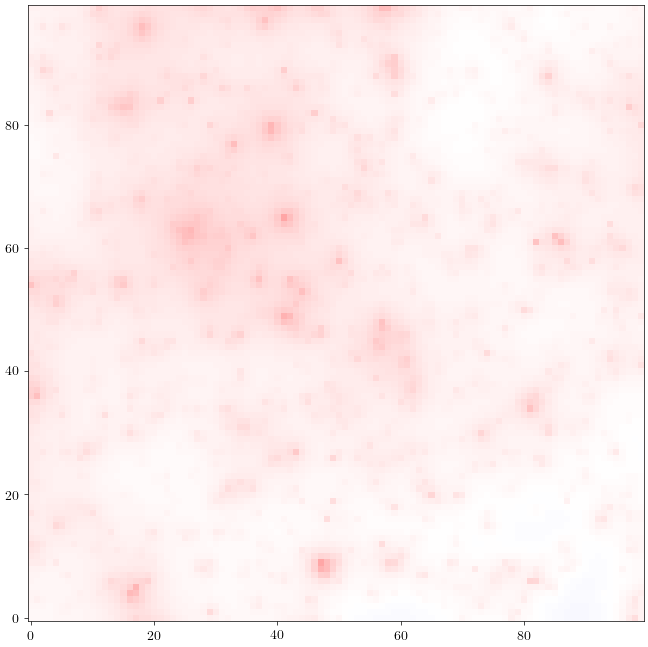

In [13]:
lens_model_halos_only = LensModel(halo_lens_model_list, lens.z_lens, lens.z_source, halo_redshift_list, cosmo=lens.cosmo, multi_plane=True)

npix = 100 
_x = _y = np.linspace(-1.2, 1.2, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_subs = lens_model_halos_only.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_subs, vmin=-0.1, vmax=0.1, cmap='bwr')

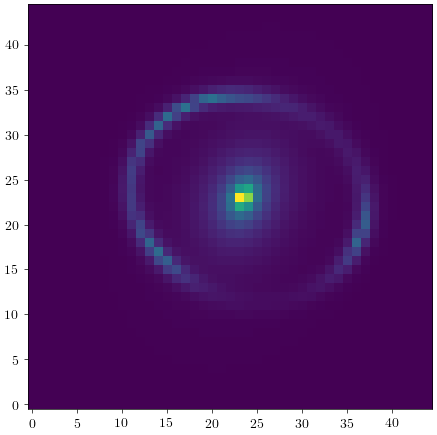

In [9]:
plot.plot(lens_with_subhalos.get_array(num_pix=45))

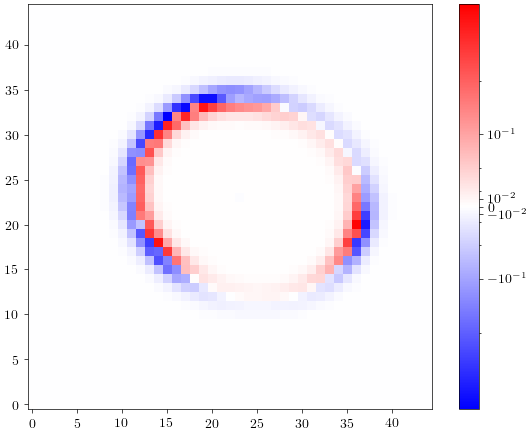

In [11]:
diagnostic_plot.residual(lens.get_array(num_pix=45), lens_with_subhalos.get_array(num_pix=45))